In [1]:
import numpy as np
import scipy.stats as ss
import pandas as pd
import matplotlib.pyplot as plt

# Introduction

Consider four different approaches to model rating evolutions over multiple periods. In particular, 
* The effect of the auto-regression is studied. 
* An incremental CWI approach is compared to a cumulative CWI approach. 

# Transition Matrix
Let's assume that there are 4 rating states \[0, 1, 2, 3\]
where 
* 0 is the best rating
* 3 is the default state

Let the following matrix $T$ is the transition matrix over a fixed period (e.g. 1-year)

In [2]:
# transtion matrix T
mtx_T = np.array([
    [0.6, 0.15, 0.15, 0.1], 
    [0.2, 0.5, 0.2, 0.1], 
    [0.05, 0.25, 0.5, 0.2], 
    [0.0, 0.0, 0.0, 1.0]])
# define the rating groups
v_ratings = np.arange(0, mtx_T.shape[0])
print(mtx_T)

[[0.6  0.15 0.15 0.1 ]
 [0.2  0.5  0.2  0.1 ]
 [0.05 0.25 0.5  0.2 ]
 [0.   0.   0.   1.  ]]


Under the Markov assumptions, the transition matrix $T(0,n)$ over $n$ periods is given by
$$ T(0, n) = T^n $$

In [3]:
def plot_rating_over_time(mtx_prob):
    v_t = 1 + np.arange(n_periods)
    for r in range(mtx_prob.shape[1]):
        plt.plot(v_t, mtx_prob[:,r], label = 'rating: ' + str(r))
    plt.legend()
    plt.xticks(v_t), plt.xlim([0, np.max(v_t)+1]), plt.ylim([-0.1, 1.1])
    plt.xlabel('period'), plt.ylabel('probability')   

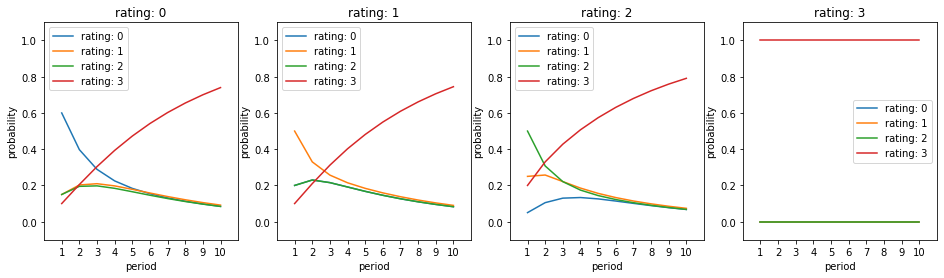

In [4]:
# calculate over next n periods
n_periods = 10
cb_T = [mtx_T]
for n in range(1, n_periods):
    cb_T.append(np.dot(cb_T[-1], mtx_T) )
cb_T = np.array(cb_T)

# show the transition probabilities over future periods
plt.figure(figsize=(4*v_ratings.size, 4))
for r in v_ratings:
    plt.subplot(100 + 10 * v_ratings.size + r + 1)
    plot_rating_over_time(cb_T[:,r,:])
    plt.title('rating: ' + str(r)), 
plt.show()

## Credit worthiness index & rating boundaries
Consider an obliger whose current rating is $r$. To model a rating transition over the period, simulate a standard normal random variable $X$, representing the change of the credit worthiness index of the obligor. 
Note that the smaller $X$, the obligor becomes more credit worthy.

The obligor's new rating is $r$ if
$$ b_{r,s-1} < \mathcal{N}(X) \le b_{r,s} $$
where
* $\mathcal{N}$ is the c.d.f of the standard normal distribution. 
* The rating boundaries $\{b_{r,s}\}$ are given by
    * $b_{r,-1} = -\infty$ and 
    * $b_{r,s} = T_{r,0} + \cdots + T_{r,s}$

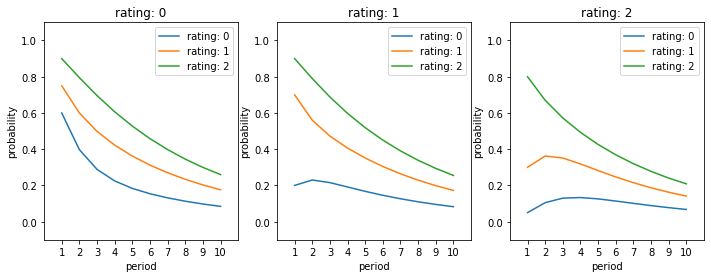

In [5]:
# boundaries. with the use of np.digitize, we need only the internal thresholds for non-default starting states. 
cb_boundary = np.cumsum(cb_T, axis = 2)[:,:-1,:-1]

plt.figure(figsize=(4*v_ratings.size, 4))
for r in v_ratings[:-1]:
    plt.subplot(100 + 10 * v_ratings.size + r + 1)
    plot_rating_over_time(cb_boundary[:,r,:])
    plt.title('rating: ' + str(r)), 
plt.show()

# Credit worthiness index simulation
For simulating CWI for the $n$-th period, denoted by $X(n)$, 
$$ X(n) = \beta S(n) + \sqrt{1- \beta^2} Z(n)$$
where
* The systematic factor $S(n)$ is an auto-regressive time series
$$ S(n) = \theta S(n-1) + \sqrt{1 - \theta^2} \epsilon(n)$$
where $\epsilon(n) \sim \mathcal{N}(0,1)$
* The idiosyncratic factor $Z(n)$ is an $\mathcal{N}(0,1)$ variable. $Z$ and $\epsilon$ are assumed to be independent. 

For rating evoluation at time step $n$, consider two approaches:
* Incremental CWI approach: The rating at time step $n$ is detemined by comparing $X(n)$ against the rating boundaries $\{b_{r,s}\}$ as above.
* Cumulative CWI approach:
    * Calculate the cumulateive CWIs:
    $$ Y(n) = \sum_{j=0}^{n} X_(n) $$
    * Set $Y(n) = \infty$ is the obliger is at the default state at time $(n-1)$
    * Sort $Y(n)$.
    * Assign the ratings according to the transition probabilities based on $T(0,n)$ for the $n$ periods

In [6]:
# global model parameters
num_scens = 100000
num_steps = n_periods
factor_loading = np.sqrt(0.5)
random_seed = 12345

def rating_simulation(ar_theta, initial_rating, use_incremental = True):
    
    np.random.seed(random_seed)
    # systematic factors, auto-regressive
    mtx_sys = np.random.standard_normal((num_scens, num_steps))
    for n in range(1, num_steps):
        mtx_sys[:,n] = ar_theta * mtx_sys[:,n-1] + np.sqrt(1 - ar_theta**2) * mtx_sys[:, n]
    
    # for CWI, combine with idiosyncratic factor
    mtx_X = factor_loading * mtx_sys
    mtx_X += np.sqrt(1 - factor_loading**2) * np.random.standard_normal((num_scens, num_steps))
    # cumulative CWI over time
    mtx_Y = np.cumsum(mtx_X, axis = 1)
    
    # now, run the rating simulations
    mtx_r = np.zeros((num_scens, num_steps+1), dtype=int)
    mtx_r[:,0] = initial_rating
    for n in range(0, num_steps):
        if use_incremental:
            mtx_r[:,n+1] = next_rating_incremental(mtx_r[:,n], mtx_X[:,n])
        else:
            mtx_r[:,n+1] = next_rating_cumulative(mtx_r[:,n], mtx_Y[:,n], cb_boundary[n, initial_rating])

    return mtx_r, mtx_X, rating_counts(mtx_r)

def next_rating_incremental(v_cur_rating, v_X):
    v_next_rating = np.zeros_like(v_cur_rating)
    for r in v_ratings:
        idx = v_cur_rating == r
        if r == v_ratings.size - 1: # i.e. the current rating is default
            v_next_rating[idx] = r
        else:
            v_next_rating[idx] = np.digitize(ss.norm.cdf(v_X[idx]), cb_boundary[0][r])
    return v_next_rating

def next_rating_cumulative(v_cur_rating, v_Y, v_boundary):
 
    v_next_rating = np.zeros_like(v_cur_rating)
    
    # first set the previously defaulted paths to default
    D_rating = v_ratings.size - 1
    v_Yc = v_Y.copy()    
    v_Yc[v_cur_rating == D_rating] = np.infty
    
    v_sorted_idx = np.argsort(v_Yc)
    
    v_rating_idx_band = np.hstack((0, [int(b * num_scens) for b in v_boundary], num_scens))
    for ib in range(v_boundary.size + 1):
        idx_s = v_rating_idx_band[ib]
        idx_e = v_rating_idx_band[ib+1]
        v_next_rating[v_sorted_idx[idx_s:idx_e]] = ib
    
    return v_next_rating


rbins = - 0.5 + np.hstack((v_ratings, v_ratings.size))
def rating_counts(mtx_r):
    mtx_c = np.zeros((v_ratings.size, mtx_r.shape[1]))
    for n in range(mtx_r.shape[1]):
        mtx_c[:, n] = np.histogram(mtx_r[:,n], rbins)[0]
    return mtx_c

v_steps = np.arange(0, num_steps + 1)

def plot_rating_paths(mtx_r, scen_idx):    
    plt.plot(v_steps, mtx_r[scen_idx, :].T)
    plt.xticks(v_steps)
    plt.yticks(v_ratings)
    plt.grid()

# Simulation samples

Consider four cases:
* incremental approach, zero auto-regressive parameters
* incremental approach, non-zero auto-regressive parameters
* cumulative approach, zero auto-regressive parameters
* cumulative approach, non-zero auto-regressive parameters

## simulations and sample plots

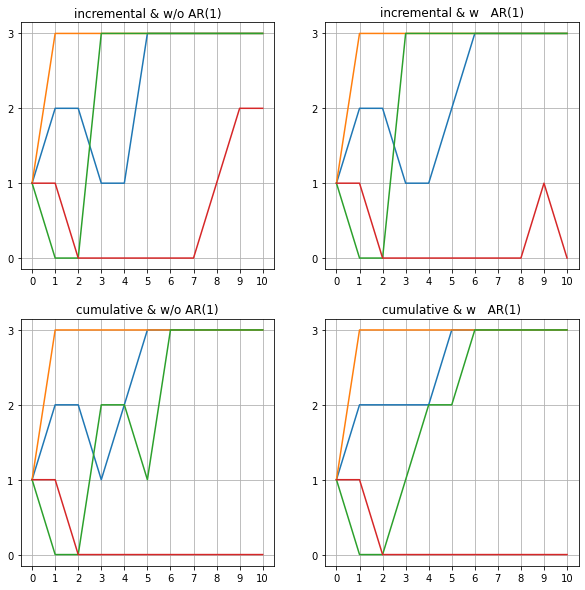

In [7]:
init_rating = 1

plot_idx = range(4)

plot_config = {'incremental & w/o AR(1)': [0.0, True],
               'incremental & w   AR(1)': [np.sqrt(0.5), True], 
               'cumulative & w/o AR(1)': [0.0, False],
               'cumulative & w   AR(1)': [np.sqrt(0.5), False],
              }

i = 1
plt.figure(figsize=[10,10])

kw_devs = {}
kw_r_scen = {}
for k,v in plot_config.items():
    
    
    # simulate
    mtx_r, mtx_X, mtx_c = rating_simulation(v[0], init_rating, v[1])
    # sample plots
    plt.subplot(220 + i)
    plot_rating_paths(mtx_r, plot_idx)
    plt.title(k)
    i += 1
    
    kw_r_scen[k] = mtx_r
    kw_devs[k] = np.round(mtx_c[:,1:] - cb_T[:, init_rating].T * num_scens, 0)
plt.show()

## show the deviation counts based on the markov transitions
* For the cumulative approach, the probabilities are recoved by construction
* For the incremental approach, having non-zero auto-regression create deviations. 

In [8]:

for k,v in kw_devs.items():
        
    print('***' + k + '***')
    print('Deviation from prediction based on the Markov model')
    print(v)
    print('*** done ***')

***incremental & w/o AR(1)***
Deviation from prediction based on the Markov model
[[ -80. -115.    2. -116.  -86. -213.  -79.  -60.  -28.  -43.]
 [ 244.  -31.  -20.   98.    9.   69.   98.  -98.  -99. -115.]
 [-118.   37. -230. -268. -225. -117.  -91.  -12.   42.   66.]
 [ -46.  109.  248.  286.  302.  260.   73.  169.   85.   92.]]
*** done ***
***incremental & w   AR(1)***
Deviation from prediction based on the Markov model
[[  -80.  2752.  5419.  7238.  8174.  8628.  8927.  8614.  8486.  8156.]
 [  244.  -981. -1553. -1618.  -998.  -589.  -121.   405.   802.  1112.]
 [ -118. -1046. -1507. -1452. -1442.  -999.  -658.   -65.   253.   679.]
 [  -46.  -725. -2359. -4168. -5734. -7041. -8147. -8955. -9541. -9947.]]
*** done ***
***cumulative & w/o AR(1)***
Deviation from prediction based on the Markov model
[[ 0.  0. -0. -0. -1. -1. -0. -1. -1. -1.]
 [ 0.  0.  0.  0.  0.  0. -0. -0.  0.  0.]
 [-1.  0. -0.  0.  0.  0.  1.  0.  0.  0.]
 [ 1. -0. -0. -0.  1.  0.  0.  0.  1.  1.]]
*** done *

## some statistics on rathing evolution paths

In [9]:
for k,mtx_r in kw_r_scen.items():
    mtx_r_diff = mtx_r[:,1:] - mtx_r[:,:-1]
    
    # num transitions
    v_num_tran = np.sum(np.abs(mtx_r_diff) > 0, axis = 1)
    
    print('*** ' + k + ' ****')
    print('transition counts')
    print(' mean: ' + str(np.mean(v_num_tran)))
    print(' std: ' + str(np.mean(v_num_tran)))
    
    
    
    # path volatilities
    v_vol = np.std(mtx_r_diff, axis = 1)

    print('rating volatility')
    print(' mean: ' + str(np.mean(v_num_tran)))
    
    print('     ')

*** incremental & w/o AR(1) ****
transition counts
 mean: 2.83045
 std: 2.83045
rating volatility
 mean: 2.83045
     
*** incremental & w   AR(1) ****
transition counts
 mean: 2.55067
 std: 2.55067
rating volatility
 mean: 2.55067
     
*** cumulative & w/o AR(1) ****
transition counts
 mean: 2.85732
 std: 2.85732
rating volatility
 mean: 2.85732
     
*** cumulative & w   AR(1) ****
transition counts
 mean: 2.49091
 std: 2.49091
rating volatility
 mean: 2.49091
     


# Observation
Based on the example, there seems to be no obvious statistical difference in the transition counts and the rating volatilities across different approaches. 

# Simulating over time steps within horizon

In [71]:
# Taylor expansion
def scale_down_tm(T, alpha, deg):
    I = np.eye(T.shape[0])
    
    x = I
    c = 1.0
    dT = I
    
    for i in range(deg):
        c *= (alpha - 1.0*i)/(1.0*i+1.0)
        dT = np.dot(dT, T-I)
        x = x + c * dT
    
    return x
    
        
deg = 1
cb_T_down = []
v_alpha = np.linspace(0.0, 1.0, 21)[:]
for alpha in v_alpha:
    cb_T_down.append(scale_down_tm(mtx_T, alpha, deg))
cb_T_down = np.array(cb_T_down)
cb_boundary_down = np.cumsum(cb_T_down, axis = 2)[:,:-1,:-1]

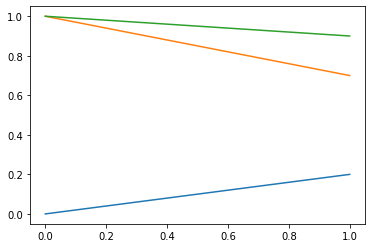

In [72]:
plt.figure()
plt.plot(v_alpha, cb_boundary_down[:,1,:])
plt.show()

In [66]:
np.cumsum(cb_T_down, axis = 2)

array([[[ 1.        ,  1.        ,  1.        ],
        [ 0.        ,  1.        ,  1.        ],
        [ 0.        ,  0.        ,  1.        ]],

       [[ 0.79568221,  1.1341675 ,  1.        ],
        [ 0.10215889,  0.83075736,  1.        ],
        [ 0.10215889,  0.13723404,  1.        ]],

       [[ 0.61704802,  1.243774  ,  1.        ],
        [ 0.19147599,  0.68663701,  1.        ],
        [ 0.19147599,  0.26106498,  1.        ]],

       [[ 0.46220051,  1.33096081,  1.        ],
        [ 0.26889975,  0.56561985,  1.        ],
        [ 0.26889975,  0.37231909,  1.        ]],

       [[ 0.329324  ,  1.397768  ,  1.        ],
        [ 0.335338  ,  0.465778  ,  1.        ],
        [ 0.335338  ,  0.471792  ,  1.        ]],

       [[ 0.21668243,  1.44613647,  1.        ],
        [ 0.39165878,  0.38527298,  1.        ],
        [ 0.39165878,  0.56024933,  1.        ]],

       [[ 0.1226178 ,  1.47791012,  1.        ],
        [ 0.4386911 ,  0.32235384,  1.        ],
        